In [52]:
from dateutil.parser import parse 
import pandas as pd
from datetime import datetime 
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib.dates as mdate

After importing the required python libraries, I read the files into data frame.The exploratory part will be analysed in the training dataset, while the permormances will be assesed in both training an testing evaluation.The complete data set is split in training and test validation. The 75% of the data is used for the training of the models and the rest is used for testing

This is a replicated work from: Data driven prediction models of energy use of appliances in a low-energy house. Luis M. Candanedo, Véronique Feldheim, Dominique Deramaix. Energy and Buildings, Volume 140, 1 April 2017, Pages 81-97, ISSN 0378-7788, http://dx.doi.org/10.1016/j.enbuild.2017.01.083.

In [81]:
#Read all the datasets
tr=pd.read_csv("data/training.csv",index_col='date', parse_dates=True)
tes=pd.read_csv("data/testing.csv",index_col='date', parse_dates=True)
print("The training dataset contains",tr.shape[0],'rows and ',tr.shape[1],'columns')
print("The testing dataset contains",tes.shape[0],'rows and ',tes.shape[1],'columns')
tr.head()

The training dataset contains 14803 rows and  31 columns
The testing dataset contains 4932 rows and  31 columns


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,WeekStatus,Day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,Weekday,Monday
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,Weekday,Monday
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,Weekday,Monday
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,Weekday,Monday
2016-01-11 17:50:00,50,40,19.89,46.026667,19.2,44.500000,19.79,44.933333,18.890000,45.730000,...,734.0,92.0,5.333333,43.833333,4.8,44.919484,44.919484,64200,Weekday,Monday


# DATA EXPLORATION

All the data analysis will be done in Python. The time span of the data set is 137 days (4.5 months).The following graph shows the energy consumption profile for the period and for the first week.

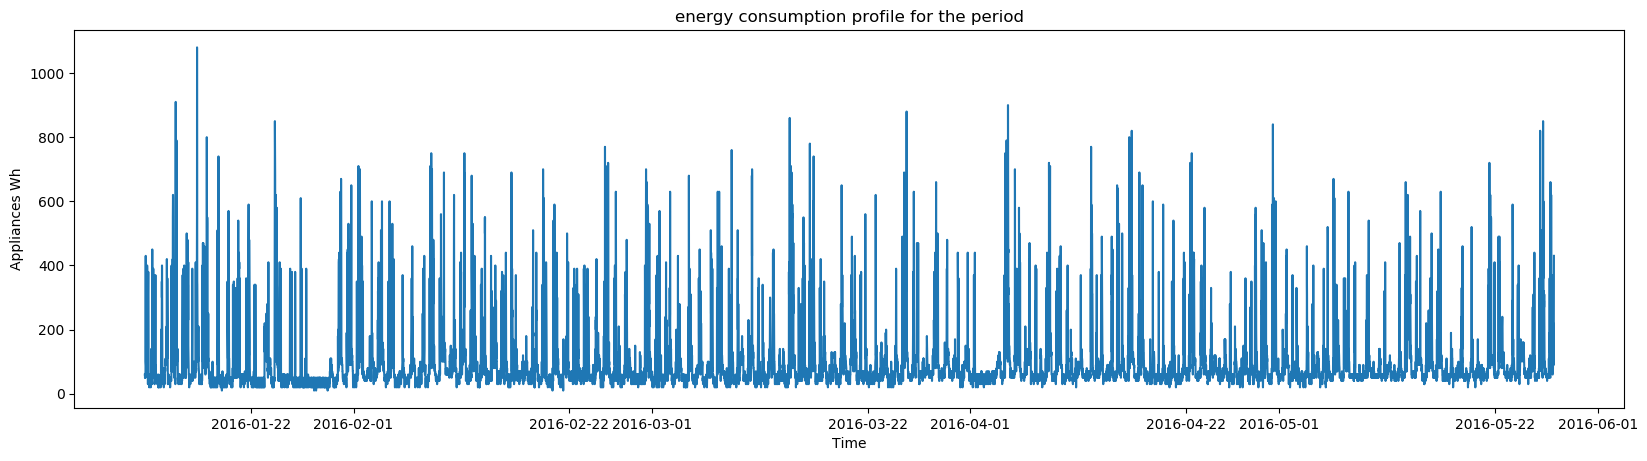

In [54]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(20,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(tr, x=tr.index, y=tr.Appliances, title='energy consumption profile for the period',xlabel='Time',ylabel='Appliances Wh') 

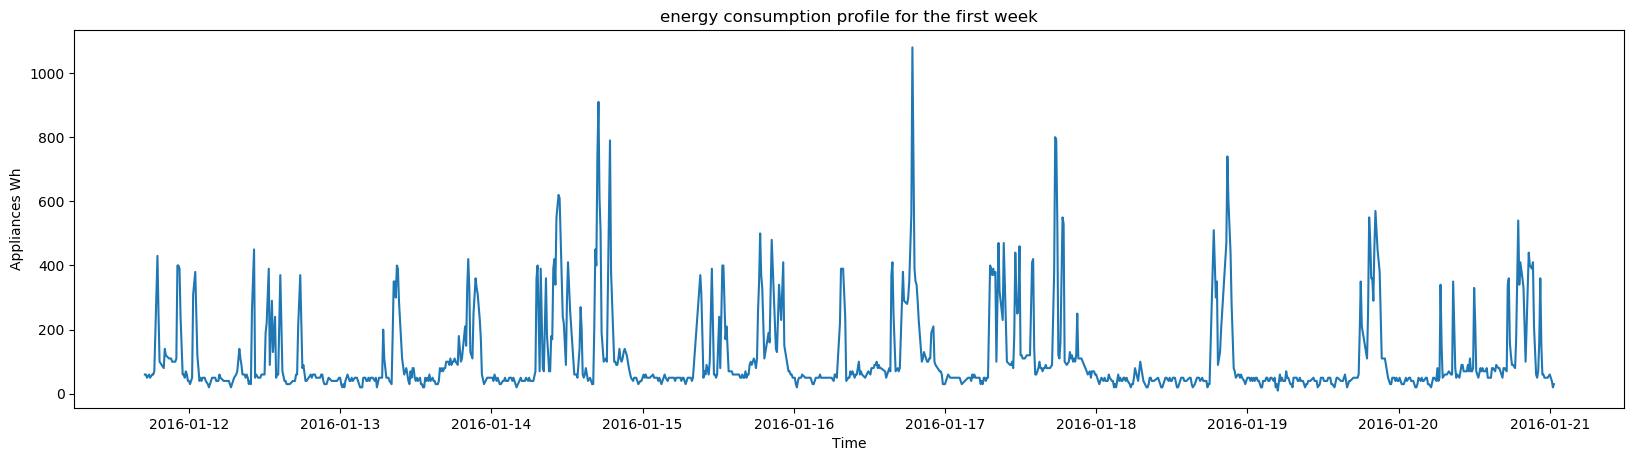

In [55]:
tr_week=tr[:1008]
plot_df(tr_week, x=tr_week.index, y=tr_week.Appliances, title='energy consumption profile for the first week',xlabel='Time',ylabel='Appliances Wh') 

The energy consumption profile shows a high variability with periods of almost constant demand followed by high spikes

The next graphs shows an histogram and boxplot of the data. 

Text(0, 0.5, 'Frequency')

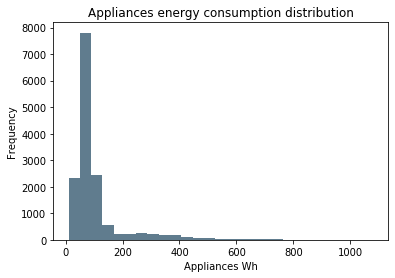

In [56]:
tr['Appliances'].plot.hist(color='#607c8e',rwidth=1,bins=27)
plt.title('Appliances energy consumption distribution')
plt.xlabel('Appliances Wh')
plt.ylabel('Frequency')


According to the graph, the data distribution has a long tail. The distribution is not symmetric and therefore skewed to the right. The majority of the values are within the range 0 to 200 Wh.

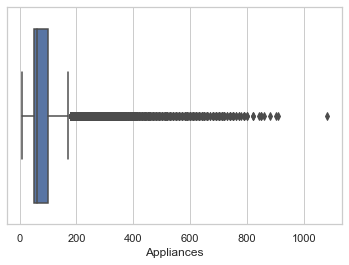

In [57]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=tr["Appliances"])

In the boxplot, the median is represented with a thick black line inside the blue rectangle, and has a value of 60 Wh.The lower whisker has a value of 10 Wh and the upper whisker has a value of 170 Wh. It also shows that the data above the median is more dispersed and that there are several outliers after the right whisker.

Next, we present pair plots showing the relationships between all the variables with the energy consumption of appliances in the training set.We create 3 different pairplots in order to split the variables and having a better visualization.
The pairplot shows the distribution of every variable in the diagonal (histogram) and the scatterplot with the regression line for every combination of variable.
In addition, a correlation matrix will be display in order to quantify these relations.Remember that a correlation of 1 is total positive correlation, −1 is total negative correlation and 0 represents no correlation.

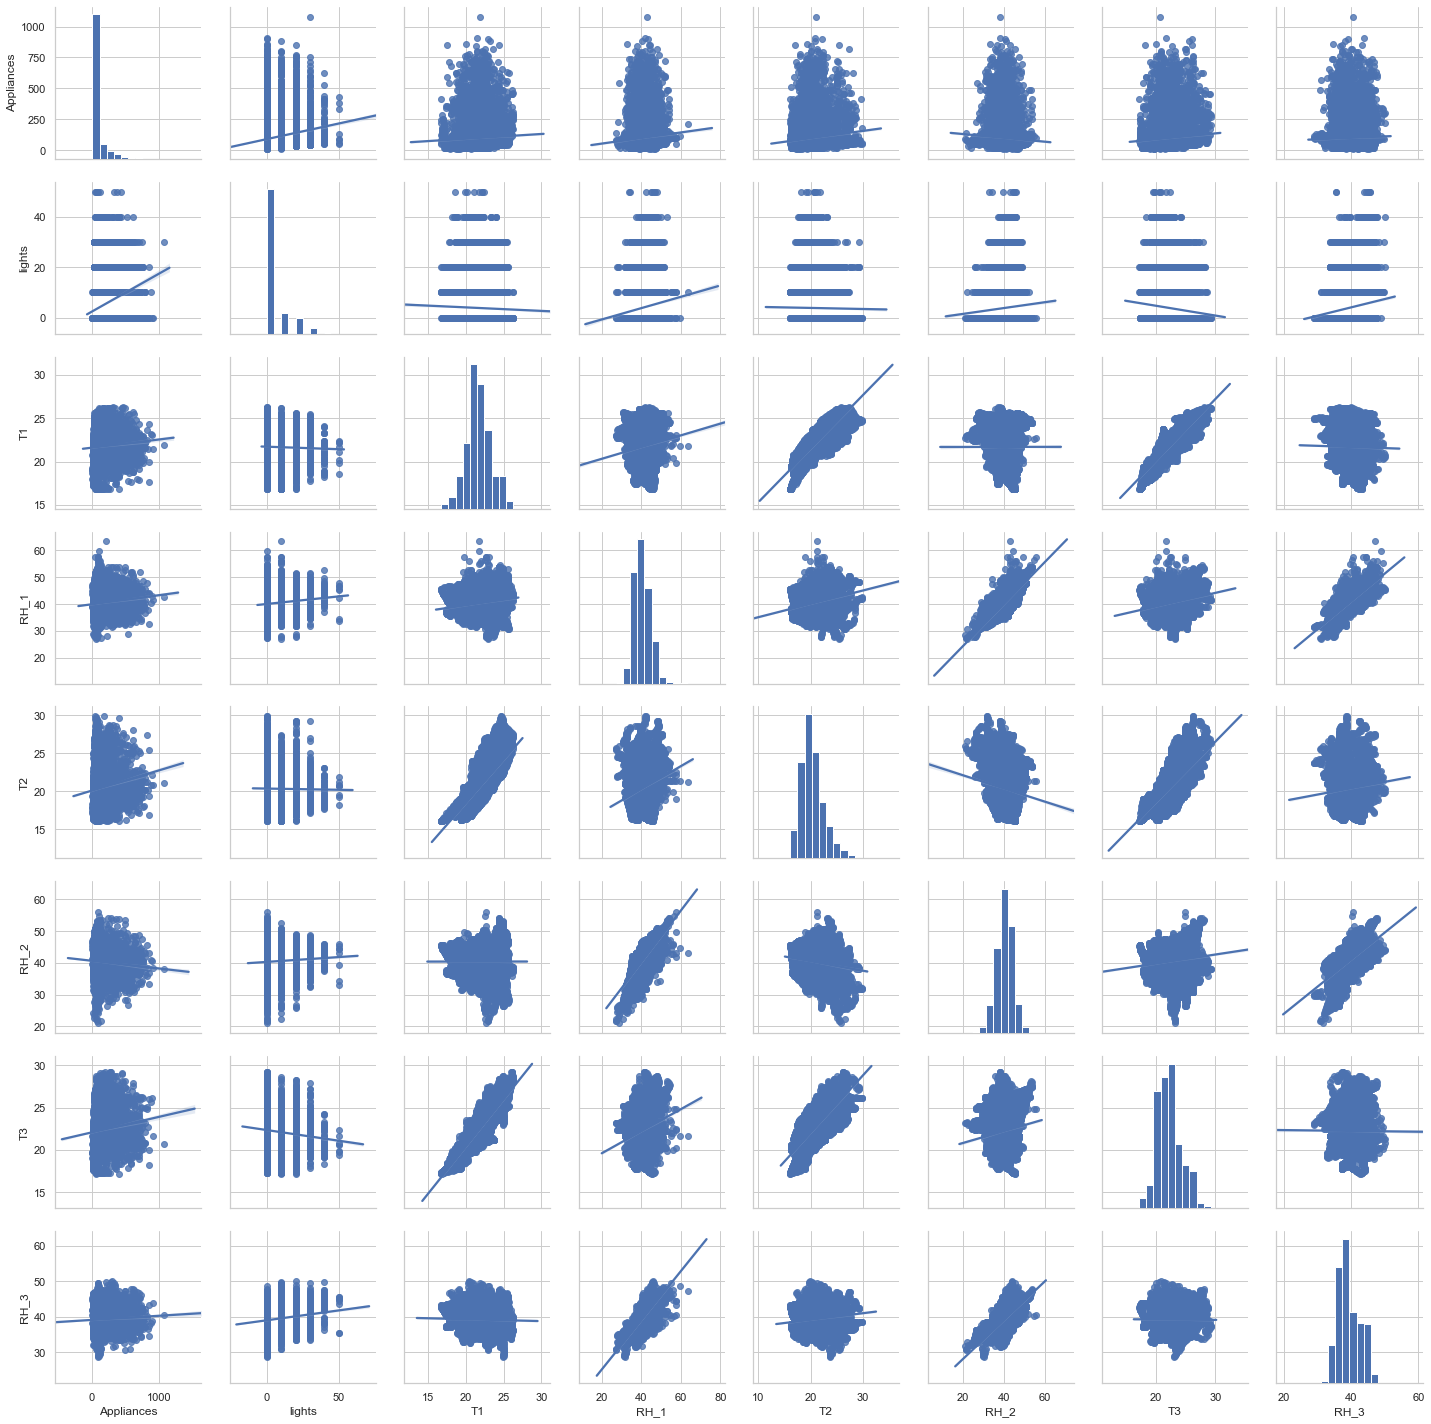

In [66]:
columns=['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3']
df=tr[columns]
sns.pairplot(df,kind='reg')


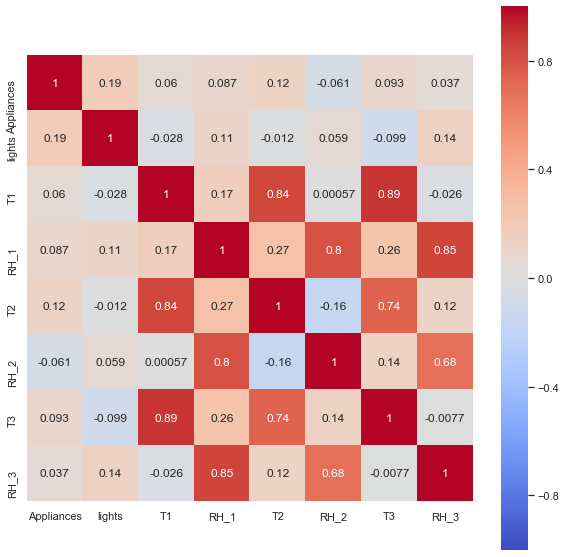

In [70]:
corrmat=df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat,vmin=-1, vmax=1, square= True,annot=True,cmap='coolwarm')

The correlation matrix above shows that there is a positive correlation between the energy consumption of appliances and lights (0.19). The second largest correlation is between appliances and T2 (0.12). For the indoor temperatures, the correlations are high as expected, since the ventilation is driven by the HRV unit and minimizes air temperature differences between rooms. For example, a positive correlationis found with T1 and T3 (0.89)

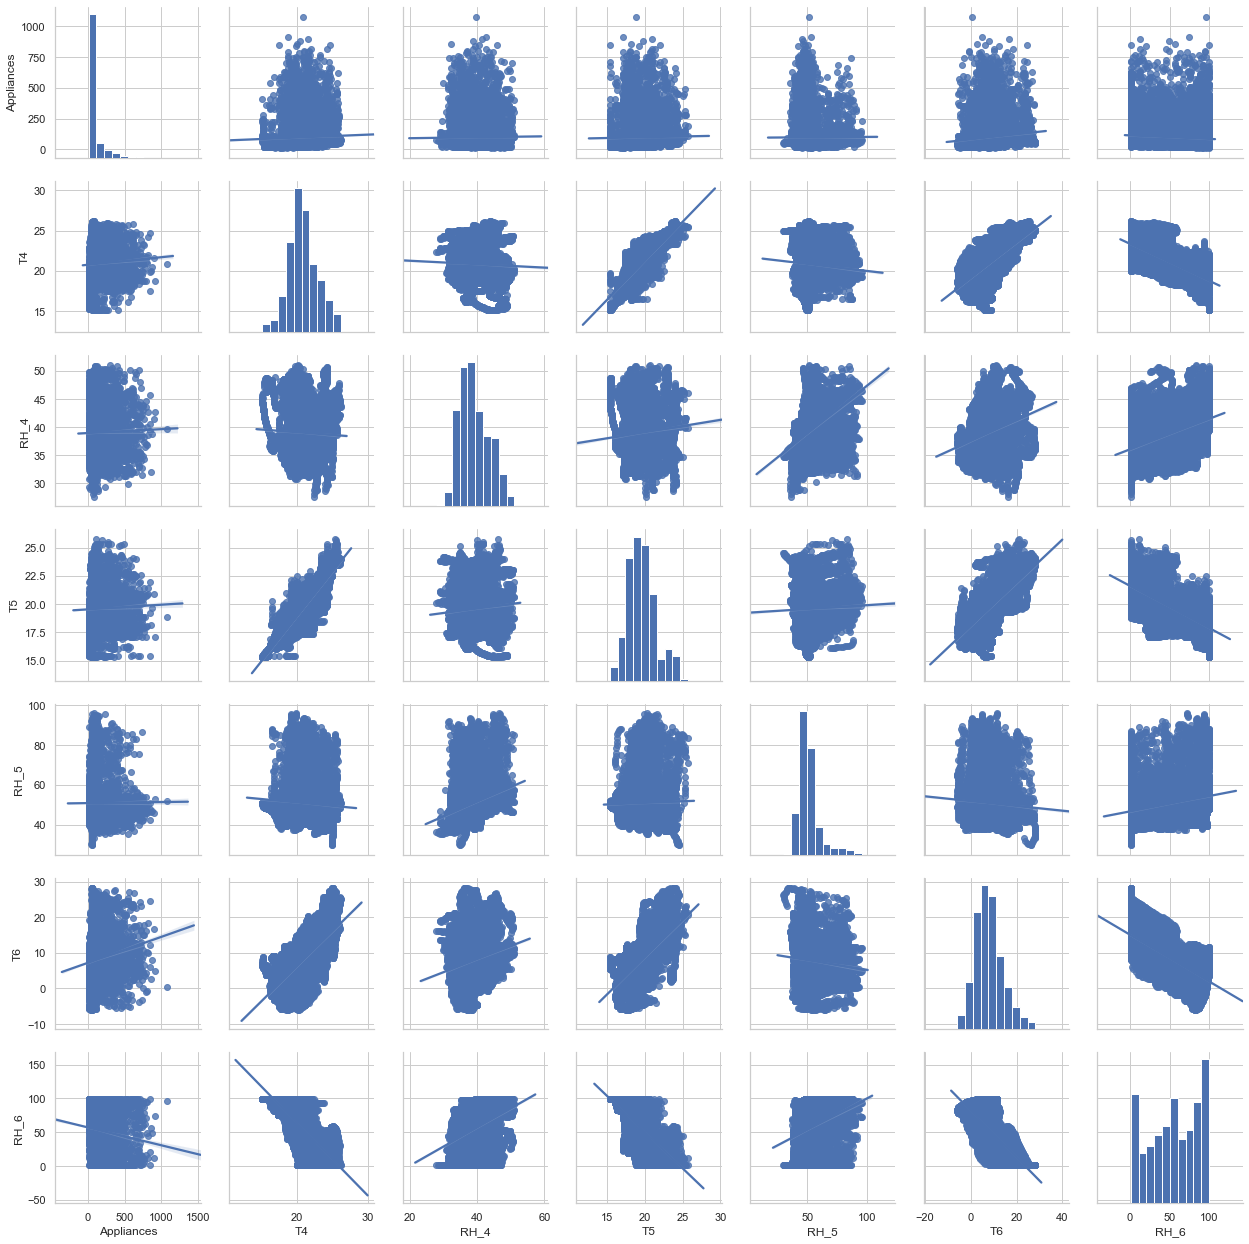

In [71]:
columns=['Appliances','T4', 'RH_4', 'T5', 'RH_5', 'T6','RH_6']
df_2=tr[columns]
sns.pairplot(df_2,kind='reg')

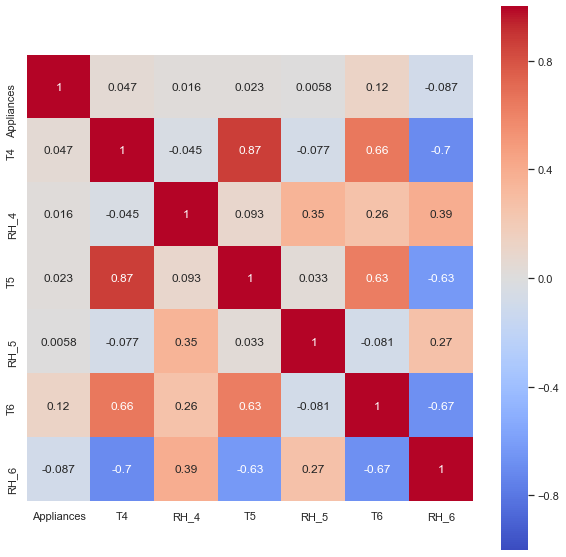

In [72]:
corrmat=df_2.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat,vmin=-1, vmax=1, square= True,annot=True,cmap='coolwarm')

The correlation matrix above shows that the highest correlation with the appliances is between the outdoor temperature (0.12).Although it is almost 0, there is also a negative correlation between the appliances and outdoor humidity/RH6 (−.09).

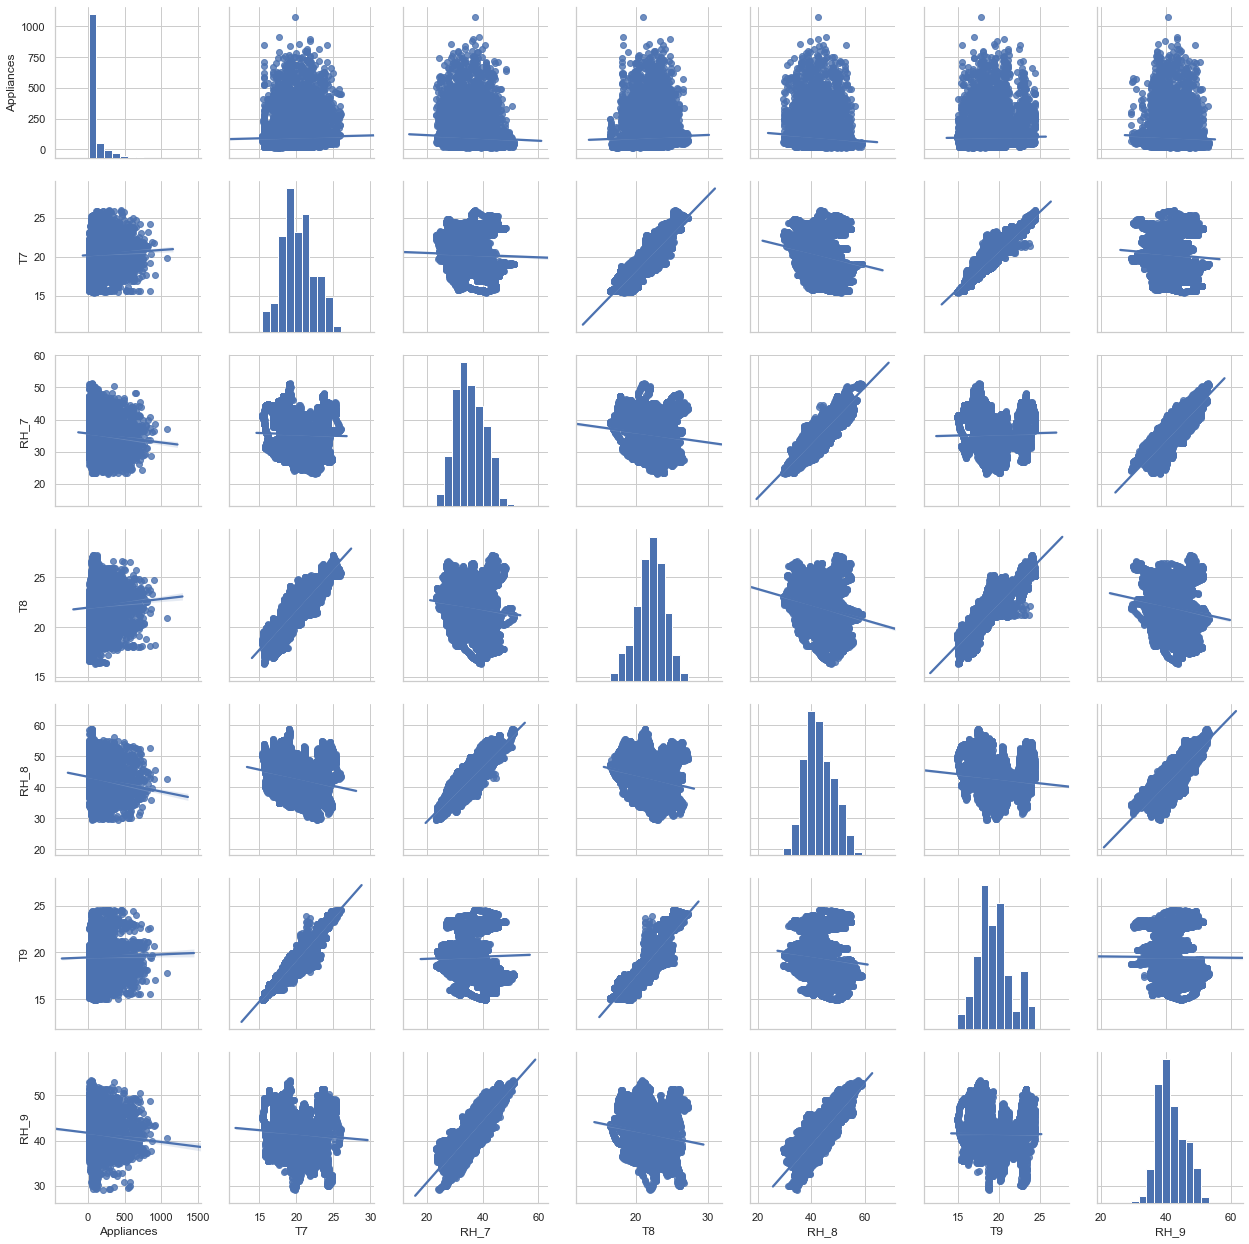

In [73]:
columns=['Appliances','T7', 'RH_7', 'T8', 'RH_8', 'T9','RH_9']
df_3=tr[columns]
sns.pairplot(df_3,kind='reg')

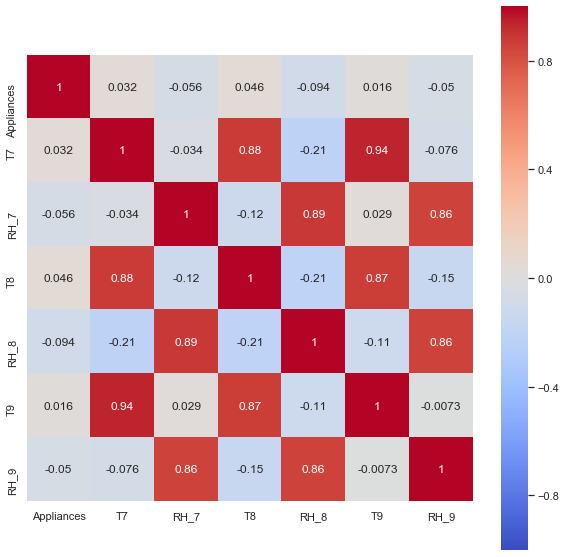

In [74]:
corrmat=df_3.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat,vmin=-1, vmax=1, square= True,annot=True,cmap='coolwarm')

This correlation matrix actually shows that there is no linear relation between Appliances and the rest of the variable. In fact all the correlations are really close to zero.

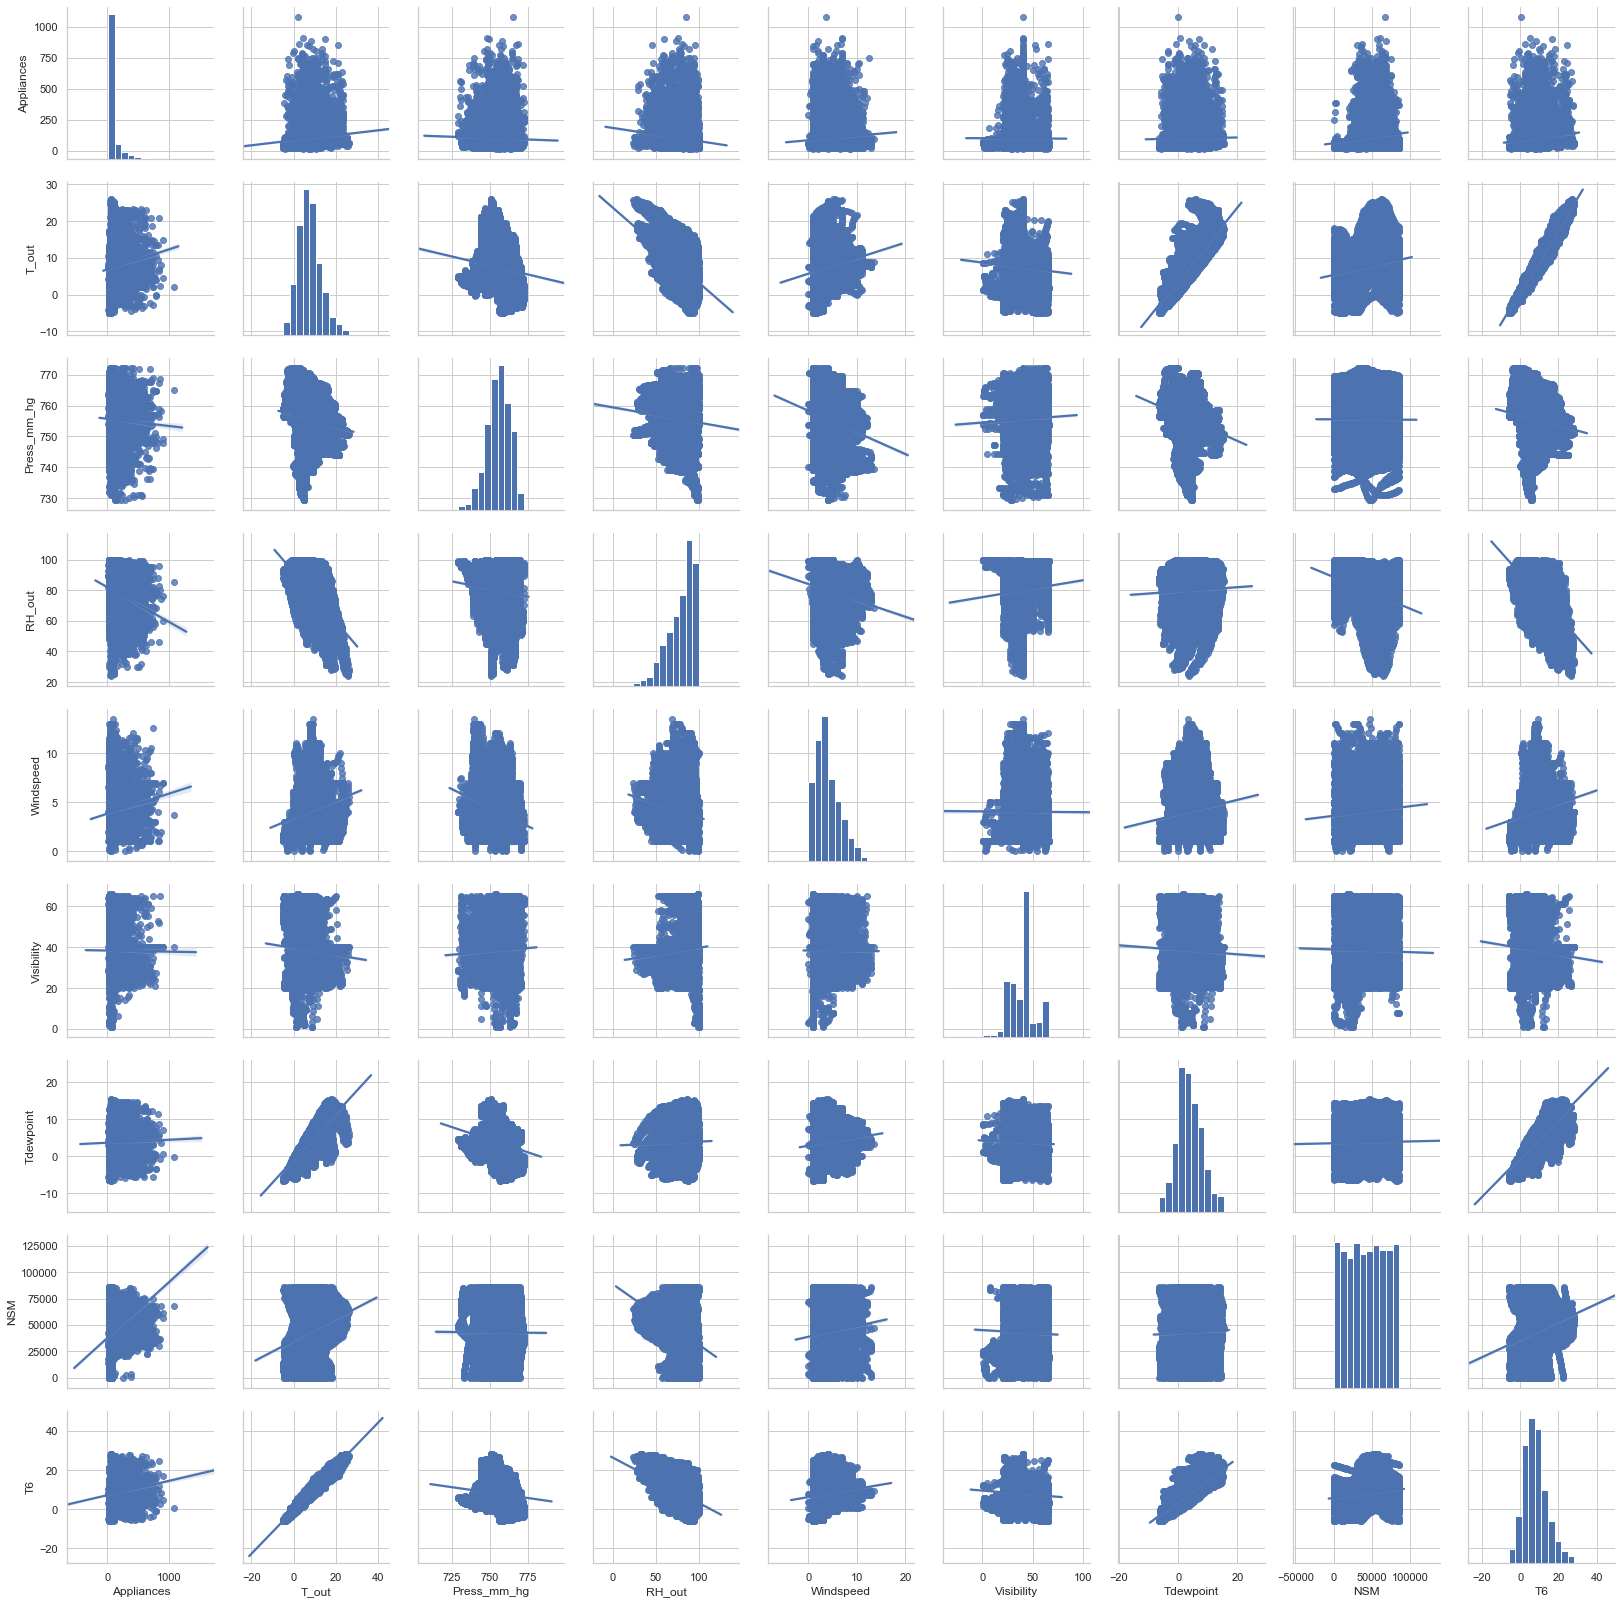

In [83]:
columns=['Appliances','T_out', 'Press_mm_hg', 'RH_out', 'Windspeed','Visibility','Tdewpoint', 'NSM','T6']
df_4=tr[columns]
sns.pairplot(df_4,kind='reg')

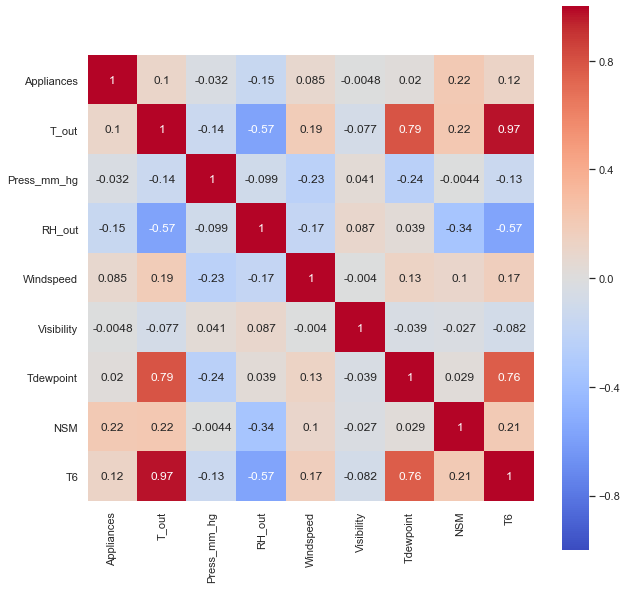

In [84]:
corrmat=df_4.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat,vmin=-1, vmax=1, square= True,annot=True,cmap='coolwarm')

The last correlation shows the highest correlation between the energy consumption of appliances and NSM with a value of 0.22.We might keep on eye on this variable since it might be a good predictor later on when we will build the regression line. A positive correlation of 0.10 is seen between appliances’ consumption and outdoor temperature (T_out) that is, the higher temperatures, the higher the energy use by the appliances.Another important and interesting correlation is between the pressure and the wind speed.This relationship is negative (−0.24). The linear trend is with lowerpressure the wind speed will be higher.

In [ ]:
######MISSING THE HEATMAP######
#####FEAUTURE SELECTION#####USE THE TOWARDS DATA SCIENCE TO COMPLETE THIS###CHECK EMAIL
####FITTING LINEAR RELATIONS#####
###WRITE SOMETHING ON THE README